## Logistic Regression based on Fundamental Approach
- Will use `kaggle` dataset of cat.
- This is based on the assignment of **Week-2** of **Deep Learning** Course by `Andrew Ng`

<img src="images/model_lr.png" style="width:600px;text-align:center">


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

### Fetch Dataset from Kaggle
- Import data from Kaggle
- Use <a href="https://www.kaggle.com/muhammeddalkran/catvnoncat" target="_blank"> this Link </a>  

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

In [3]:
# Loading the data (cat/non-cat) from the File downloaded from the Kaggle
train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")

In [4]:
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
train_set_y = np.array(train_dataset["train_set_y"][:]) # your train set labels

In [5]:
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
test_set_y = np.array(test_dataset["test_set_y"][:]) # your test set labels

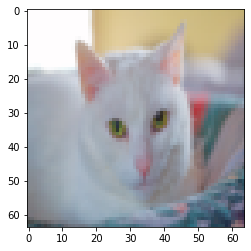

In [6]:
index = 2
plt.imshow(test_set_x_orig[index])

In [7]:
train_set_y.shape

(209,)

In [8]:
train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))

In [9]:
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=train_set_x_orig.shape[1]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64


In [10]:
train_set_x_orig.shape

(209, 64, 64, 3)

The shape of **`X`** matrix is $\mathcal {(nx, m)}$ where each columns represents the features of each training set; 

Where,   

$\mathcal {nx=px * py * 3}$ for the images as input and $m$ is the training examples.

<img src="images/matrix_xwy_lr.png" style="width:500px;text-align:center">   

So, we have to reshape to `train_set_x_orig` to `(nx,m_train)`. This will be achieved in two steps:   

***Step-1*** : Respahe `train_set_x_orig` to `(train_set_x_orig.shape[0],-1)`. -1 is used for unknown number of columns (known presently as `nx`)   
***Step-2*** : Transpose the matrix to get the desired dimension `(nx, m)`.

In [11]:
train_set_x_flatten=train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten=test_set_x_orig.reshape (test_set_x_orig.shape[0],-1).T

In [12]:
train_set_x_flatten.shape

(12288, 209)

Optimizing the parameters on the is best suited on the data of the same range. Let's normalize our dataset with the maximum possible pixel value i.e. 255.

In [13]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.
features=train_set_x.shape[0]
features

12288

## Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)


In [14]:
# sigmoid FUNCTION: sigmoid
def sigmoid(z):
#    z -- A scalar or numpy array of any size.
    s=1/(1+np.exp(-z))
    return s

In [15]:
print ("sigmoid([-1, 0, 1]) = " + str(sigmoid(np.array([-1,0,1]))))

sigmoid([-1, 0, 1]) = [0.26894142 0.5        0.73105858]


In [16]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    
    # (≈ 2 lines of code)
    # w = ...
    # b = ...
    # YOUR CODE STARTS HERE
    w=np.zeros(dim).reshape(dim,1)
    b=0.0
    # YOUR CODE ENDS HERE

    return w, b

In [17]:
dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print ("w = " + str(w))
print ("b = " + str(b))


w = [[0.]
 [0.]]
b = 0.0


In [18]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    #(≈ 2 lines of code)
    # compute activation
    # A = ...
    # compute cost by using np.dot to perform multiplication. 
    # And don't use loops for the sum.
    # cost = ...                                
    # YOUR CODE STARTS HERE
    A=sigmoid(np.dot(w.T,X)+b)
    cost=-np.sum((Y*np.log(A)+(1-Y)*np.log(1-A)),axis=1)/m
    # YOUR CODE ENDS HERE

    # BACKWARD PROPAGATION (TO FIND GRAD)
    #(≈ 2 lines of code)
    # dw = ...
    # db = ...
    # YOUR CODE STARTS HERE
    dw=np.dot(X,(A-Y).T)/m
    db=(np.sum((A-Y), dtype=np.float64))/m
    # YOUR CODE ENDS HERE
    cost = np.squeeze(np.array(cost))
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [19]:
w =  np.array([[1.], [2]])
b = 1.5
X = np.array([[1., -2., -1.], [3., 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))


dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.12500404500439652
cost = 0.15900537707692405


In [20]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        # (≈ 1 lines of code)
        # Cost and gradient calculation 
        # grads, cost = ...
        # YOUR CODE STARTS HERE
        grads, cost = propagate(w, b, X, Y)
        
        # YOUR CODE ENDS HERE
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        # w = ...
        # b = ...
        # YOUR CODE STARTS HERE
        w=w-learning_rate*dw
        b=b-learning_rate*db
        
        # YOUR CODE ENDS HERE
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [21]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))


w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = [array(0.15900538)]


In [22]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    #(≈ 1 line of code)
    # A = ...
    # YOUR CODE STARTS HERE
    A=sigmoid(np.dot(w.T,X)+b)
    # YOUR CODE ENDS HERE
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        #(≈ 4 lines of code)
        # if A[0, i] > ____ :
        #     Y_prediction[0,i] = 
        # else:
        #     Y_prediction[0,i] = 
        # YOUR CODE STARTS HERE
        if A[0,i] > 0.5:
            Y_prediction[0,i]=1
        else:
            Y_prediction[0,i]=0
        # YOUR CODE ENDS HERE
    
    return Y_prediction

In [23]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))


predictions = [[1. 1. 0.]]


In [24]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.05, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    # (≈ 1 line of code)   
    # initialize parameters with zeros 
    # w, b = ...
    
    #(≈ 1 line of code)
    # Gradient descent 
    # params, grads, costs = ...
    
    # Retrieve parameters w and b from dictionary "params"
    # w = ...
    # b = ...
    
    # Predict test/train set examples (≈ 2 lines of code)
    # Y_prediction_test = ...
    # Y_prediction_train = ...
    
    # YOUR CODE STARTS HERE
    w, b=np.zeros(X_train.shape[0]).reshape(X_train.shape[0],1),0.0
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    Y_prediction_train=predict(params["w"], params["b"], X_train)
    Y_prediction_test=predict(params["w"], params["b"], X_test)
    # YOUR CODE ENDS HERE

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : params["w"], 
         "b" : params["b"],
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return d

In [25]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.05, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 1.025272


ipykernel_launcher:31: RuntimeWarning: divide by zero encountered in log
ipykernel_launcher:31: RuntimeWarning: invalid value encountered in multiply


Cost after iteration 200: 10.758017
Cost after iteration 300: 2.723789
Cost after iteration 400: 10.454995
Cost after iteration 500: 10.099740
Cost after iteration 600: 0.075759
Cost after iteration 700: 0.023104
Cost after iteration 800: 0.016444
Cost after iteration 900: 0.013325
Cost after iteration 1000: 0.011448
Cost after iteration 1100: 0.010160
Cost after iteration 1200: 0.009202
Cost after iteration 1300: 0.008451
Cost after iteration 1400: 0.007842
Cost after iteration 1500: 0.007336
Cost after iteration 1600: 0.006905
Cost after iteration 1700: 0.006534
Cost after iteration 1800: 0.006210
Cost after iteration 1900: 0.005923
train accuracy: 100.0 %
test accuracy: 66.0 %


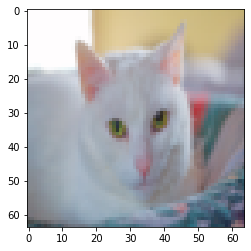

In [26]:
# Example of a picture that was wrongly classified.
index = 2
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))


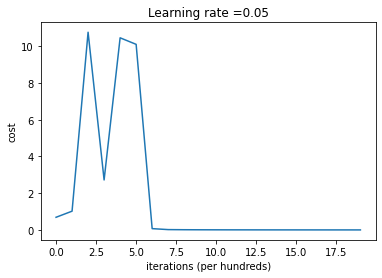

In [27]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()